# 1)Import necessary libraries

In [1]:
import torch 
import torchvision
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.optim as optim
import torchvision.models as models
from torchvision.utils import make_grid

import time
import os
import copy
import matplotlib.pyplot as plt
%matplotlib inline

# 2) Prepairing data,making dataloader

In [2]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 32
# percentage of training set to use as validation
valid_size = 0.2

#Using the mean and std of Imagenet is a common practice. They are calculated based on millions of images.
#Using the Imagenet pretrianed model with its own mean and std is recommended.
stats = ((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# convert data to a normalized torch.FloatTensor
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

In [3]:
data_dir='../input/flowers-recognition/flowers/flowers'
print(os.listdir(data_dir))

['dandelion', 'daisy', 'sunflower', 'tulip', 'rose']


In [4]:
dataset = datasets.ImageFolder(data_dir, transform=train_transforms)

len_train_set = int(0.8*len(dataset))
len_test_set = len(dataset) - len_train_set
# repare datasets.train_data will be use for training,and test_data for final test
train_data, test_data = torch.utils.data.random_split(dataset, [len_train_set, len_test_set])

In [5]:
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers,sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers,sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

In [6]:
# Function making denormalizing images
def denormalize(images, means, stds):
    if len(images.shape) == 3:
        images = images.unsqueeze(0)
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_image(img_tensor, label):
    print('Label:', dataset.classes[label], '(' + str(label) + ')')
    img_tensor = denormalize(img_tensor, *stats)[0].permute((1, 2, 0))
    plt.imshow(img_tensor)
    

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        images = denormalize(images, *stats)
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0),)
        print(' '.join('%15s' % dataset.classes[int(label)] for label in labels))
        break

      sunflower       sunflower           daisy       sunflower           daisy       sunflower       dandelion           tulip       dandelion           daisy           daisy           tulip       dandelion           daisy           tulip           daisy           daisy       sunflower       dandelion            rose       sunflower           daisy       dandelion           daisy           tulip       dandelion       sunflower            rose           tulip           tulip           daisy       sunflower


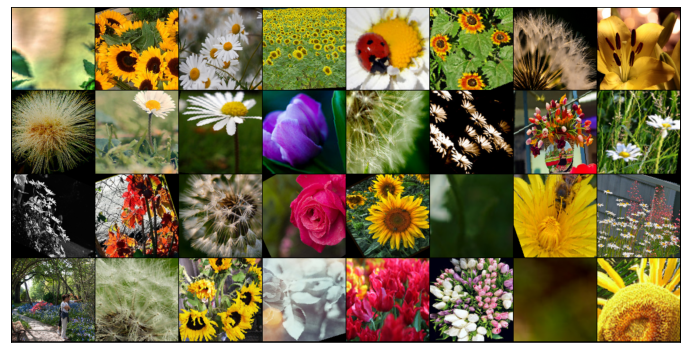

In [7]:
show_batch(train_loader)

Label: daisy (0)


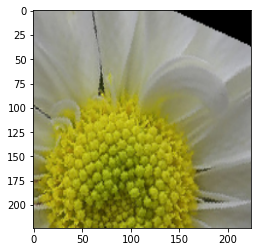

In [8]:
show_image(*dataset[0])

# 3) Training stage

In [9]:
# we are using  pretrained on ImageNet model resnet34
model_conv = torchvision.models.resnet34(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = torch.nn.Linear(num_ftrs, 5)

model_conv = model_conv.to(device)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [10]:
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

criterion = torch.nn.CrossEntropyLoss()

dataloaders = {'train': train_loader, 'val': valid_loader}
dataset_sizes = {x: len(dataloaders[x]) for x in ['train', 'val']}

In [11]:
def train_model(model, criterion, optimizer,scheduler, num_epochs=25):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [12]:
model_ft = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler,num_epochs=25)

Epoch 0/24
----------
train Loss: 33.2461 Acc: 19.4368
val Loss: 21.4227 Acc: 24.3636

Epoch 1/24
----------
train Loss: 20.9074 Acc: 24.3103
val Loss: 17.9344 Acc: 25.4545

Epoch 2/24
----------
train Loss: 19.0473 Acc: 25.0230
val Loss: 15.7395 Acc: 26.1364

Epoch 3/24
----------
train Loss: 17.6295 Acc: 25.6092
val Loss: 15.3413 Acc: 26.1818

Epoch 4/24
----------
train Loss: 16.2990 Acc: 26.1264
val Loss: 14.7292 Acc: 26.2727

Epoch 5/24
----------
train Loss: 16.3077 Acc: 25.8736
val Loss: 13.5521 Acc: 26.5455

Epoch 6/24
----------
train Loss: 15.9578 Acc: 26.0115
val Loss: 12.3788 Acc: 27.5455

Epoch 7/24
----------
train Loss: 14.7325 Acc: 26.6897
val Loss: 12.7088 Acc: 27.0455

Epoch 8/24
----------
train Loss: 15.0871 Acc: 26.3218
val Loss: 12.2495 Acc: 27.5455

Epoch 9/24
----------
train Loss: 14.7480 Acc: 26.7701
val Loss: 13.3661 Acc: 26.7273

Epoch 10/24
----------
train Loss: 14.7182 Acc: 26.4023
val Loss: 12.7371 Acc: 26.9545

Epoch 11/24
----------
train Loss: 14.9933

# 4) Test stage

In [13]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(dataset.classes[preds[j]]))
                plt.imshow(inputs[j].cpu().permute(1, 2, 0).clamp(0, 1))

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

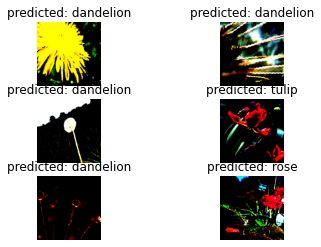

In [14]:
visualize_model(model_conv)

In [15]:
result = 0
counter = 0
with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model_conv(inputs)
            _, preds = torch.max(outputs, 1)
            result += int(sum(labels == preds))
            counter += len(labels)
        
print('Correct_answers - {0}, Total_answers - {1}, Percent_corrects - {2}'.format(result, counter,result/counter))

Correct_answers - 732, Total_answers - 865, Percent_corrects - 0.846242774566474


# Conclusion
1) Our model has the final_score=85%.It's not bad
2)We can try to use another model for training(efficientnet,googlenet e.g.)
3)We can try another optimizer(Adam)
4)We can try another scheduler